In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.linalg import eigs, eigsh
from scipy import sparse

import torch
from torch import lobpcg

import plotly.graph_objs as go

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from skimage import measure

In [4]:
N = 120
X, Y, Z = np.mgrid[-25:25:N*1j, -25:25:N*1j, -25:25:N*1j]
dx = np.diff(X[:,0,0])[0]

In [5]:
def get_potential(x, y, z):

    return -dx**2 /np.sqrt(x**2 + y**2 + z**2 + 1e-10)

V = get_potential(X,Y,Z)

In [6]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1, 0, 1]), N, N)
T = -1/2 * sparse.kronsum(sparse.kronsum(D,D),D)
U = sparse.diags(V.reshape(N**3), (0))
H = T + U

In [7]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor(np.array([H.row, H.col])), values = torch.tensor(H.data), size = H.shape).to(device)

In [8]:
eigenvalues, eigenvectors = lobpcg(H, k=15, largest=False)

KeyboardInterrupt: 

In [ ]:

eigenvalues

tensor([-0.0849, -0.0222, -0.0222, -0.0222, -0.0218, -0.0098, -0.0098, -0.0098,
        -0.0098, -0.0098, -0.0098, -0.0098, -0.0098, -0.0097, -0.0053],
       device='cuda:0', dtype=torch.float64)

In [ ]:
hbar = 1.055e-34
a = 5.29e-11
m = 9.11e-31
J_to_ev = 6.242e18
conversion = hbar**2 / m / dx**2 / a**2 * J_to_ev

In [ ]:
k = np.linspace(0, len(eigenvalues)-1, len(eigenvalues))

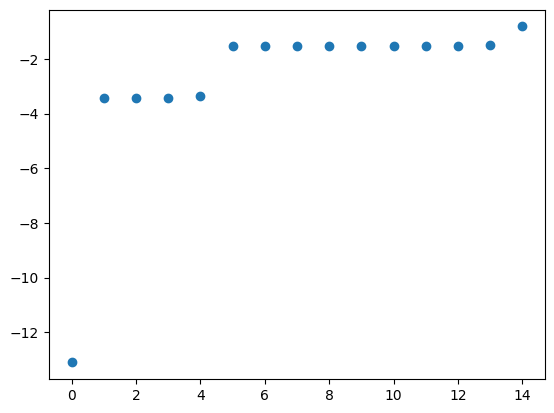

In [ ]:
fig, ax = plt.subplots()
ax.scatter(k, eigenvalues.cpu() * conversion)

plt.show()

In [ ]:
def get_e(n):

    return eigenvectors.T[n].reshape(N,N,N).cpu().numpy()

In [ ]:
verts, faces, _, _ = measure.marching_cubes(get_e(2)**2, 1e-6, spacing=(0.1, 0.1, 0.1))
intensity = np.linalg.norm(verts, axis=1)

In [ ]:
fig = go.Figure(data = [go.Mesh3d(x=verts[:,0], y=verts[:,1], z=verts[:,2],
                                    i = faces[:,0], j=faces[:,1], k = faces[:,2],
                                    intensity=intensity,
                                    colorscale='Agsunset',
                                    opacity=0.5)])

fig.update_layout(scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False),
                             bgcolor='rgb(0,0,0)'),
                             margin = dict(l=0, r=0, b=0, t=0))

fig.show()